In [1]:
from utils import plot_history, plot_result, calc_mean_image_metrics, predict_all
from losses import ssim_l2

In [14]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Subtract, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, PReLU, LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
images_clear_tt = np.load('images_clear_tt.npy')
images_noised_tt = np.load('images_noised_tt.npy')
images_clear_tt = images_clear_tt[:50]
images_noised_tt = images_noised_tt[:50]

In [4]:
#images_noised_train, images_noised_test, images_clear_train, images_clear_test = train_test_split(images_noised_tt,
#                                                                                                 images_clear_tt,
#                                                                                                 test_size=0.2,
#                                                                                                 random_state=42)

In [4]:
def dncnn_res_gan(img_shape):

    input = Input(img_shape)
    n_blocks = 24
    x = Conv2D(128, kernel_size=(3,3),  bias_initializer='glorot_normal',
                                        kernel_initializer='glorot_normal',
                                        padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(n_blocks):
        xx = Conv2D(128, kernel_size=(3,3),  bias_initializer='glorot_normal', 
                                             kernel_initializer='glorot_normal',
                                             padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3),  bias_initializer='glorot_normal', 
                                      kernel_initializer='glorot_normal',
                                      padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    
    return model

In [15]:
def generator():
    model = dncnn_res_gan((256,256,3))
    #model.load_weights('dncnn_res_pretrained/dncnn_res')
    return model

In [ ]:
def discriminator():
    
    img_shape = (256, 256, 3)
    
    input = Input(img_shape)
    x = Conv2D(64, kernel_size=(3,3), padding='same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()
    
    return model

In [6]:
def discriminator_v2():
    
    img_shape = (256, 256, 3)
    
    input = Input(img_shape)
    
    x = Conv2D(3, kernel_size=(3,3), padding='same')(input)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(512, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)    
    
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()
    
    return model

In [ ]:
D = discriminator_v2()
D.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
D.fit(images_all, images_all_y, epochs=30, shuffle=True, batch_size=16)

In [7]:
class denoiser_gan(Model):
    
    img_shape = (256, 256, 3)
    
    def __init__(self, generator, discriminator):
        super (denoiser_gan, self).__init__()
        self.G = generator
        self.D = discriminator
        #self.build((None,256,256,3))

        
#    def compile (self, g_optimizer, d_optimizer, loss):
#        super(denoiser_gan, self).compile()
#        self.G.optimizer = g_optimizer
#        self.D.optimizer = d_optimizer
#        self.G.loss = loss
#        self.D.loss = loss
        #self.loss = loss
        

#    def train_step(self, data):
        
#        images_noised, images_clear = data
        
#        images_reconstructed = self.G(images_noised) #, training=True)
        
#        with tf.GradientTape() as tape:
#            fake_out = self.D(images_reconstructed + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)))#, training=True)
#            real_out = self.D(images_clear + 0.05 * tf.random.uniform(tf.shape(images_reconstructed))) #, training=True)
#            d_real_loss = self.D.loss(tf.ones_like(real_out), real_out)
#            d_fake_loss = self.D.loss(tf.zeros_like(fake_out), fake_out)
#            d_loss = d_real_loss + d_fake_loss

#            d_grads = tape.gradient(d_loss, self.D.trainable_variables)
#            self.D.optimizer.apply_gradients(zip(d_grads, self.D.trainable_weights))
            
        #images_reconstructed = self.G(images_noised, training=True)
        
#        with tf.GradientTape() as tape:
#            fake_out = self.D(self.G(images_reconstructed)) # + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)))) #, training=True)
#            g_loss_adv = self.G.loss(tf.ones_like(fake_out), fake_out)
#            g_loss_content = 0 # tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            #g_loss_content = ssim_l2(images_clear, images_reconstructed)
#            g_loss = g_loss_adv # tf.constant([0.9])*g_loss_adv + tf.constant([0.1])*g_loss_content
            
#        g_grads = tape.gradient(g_loss, self.G.trainable_variables)
#        self.G.optimizer.apply_gradients(zip(g_grads, self.G.trainable_weights))

#        ssim = tf.image.ssim(images_clear, images_reconstructed, max_val=1.)
        
#        return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_adv" :g_loss_adv, "g_cont": g_loss_content, "g_loss": g_loss, "ssim" : ssim}



    def train_step(self, data):        
        images_noised, images_clear = data

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

            images_reconstructed = self.G(images_noised, training=True)

            real_out = self.D(images_clear + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)
            fake_out = self.D(images_reconstructed + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)

            d_real_loss = D.loss(tf.ones_like(real_out), real_out)
            d_fake_loss = D.loss(tf.zeros_like(fake_out), fake_out)
            d_loss = d_real_loss + d_fake_loss
                        
            g_loss_adv = G.loss(tf.ones_like(fake_out), fake_out)
            g_loss_content = tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            #g_loss_content = ssim_l2(images_clear, images_reconstructed)
            g_loss = g_loss_adv + tf.constant([0.1])*g_loss_adv + tf.constant([0.9])*g_loss_content
            
            
        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        
        self.G.optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.D.optimizer.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        ssim = tf.image.ssim(images_clear, images_reconstructed, max_val=1.)
        
        #return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_loss": g_loss, "ssim" : ssim}
        return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_adv" :g_loss_adv, "g_cont": g_loss_content, "g_loss": g_loss, "ssim" : ssim}

    def train(self, data, epochs):
        h = []
        for epoch in range(epochs):
            for batch in data:
                history = self.train_step(batch)
                h.append(history)
                im_c, im_n = batch
            print (f'epoch {epoch}/{epochs} ssim:{history.ssim}')
        return h
            
        
    
    def call(self, inputs):
        return self.G(inputs)
    
    
    
    def predict(self, inputs):
        return self.G.predict(inputs)
    
    #############################   tf.print()

In [ ]:
batch_size = 1
G = generator()
#G.load_weights('dncnn_res_pretrained/dncnn_res')
D = discriminator_v2()
#D.load_weights('d_pretrained\discr_v2')
dngan = denoiser_gan(G, D)
g_opt = Adam(learning_rate=2e-4, beta_1=0.5)
d_opt = Adam(learning_rate=1e-5, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy()

#dngan.summary()

#D.compile(d_opt, loss)
#G.compile(g_opt, loss)
#dngan.compile(Adam(learning_rate=2e-4, beta_1=0.5), loss)
dngan.D.trainable=False
dngan.compile(g_opt, d_opt, loss)
history = dngan.fit(images_noised[:50], images_clear[:50],
                    epochs=200,
                    batch_size=1
                   )

In [ ]:
G = generator()
#G.load_weights('dncnn_res_pretrained/dncnn_res')
D = discriminator_v2()
#D.load_weights('d_pretrained\discr_v2')
dngan = denoiser_gan(G, D)
G.optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
D.optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
G.loss = tf.keras.losses.BinaryCrossentropy()
D.loss = tf.keras.losses.BinaryCrossentropy()

ds_noised = tf.data.Dataset.from_tensor_slices(images_noised_tt).batch(1)
ds_clear = tf.data.Dataset.from_tensor_slices(images_clear_tt).batch(1)
train_data = tf.data.Dataset.zip((ds_noised, ds_clear))

dngan.train(train_data, epochs=2000)
#history = dngan.fit(images_noised[:100], images_clear[:100],
#                    epochs=200,
#                    batch_size=1)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_129 (Conv2D)            (None, 256, 256, 12  3584        ['input_9[0][0]']                
                                8)                                                                
                                                                                                  
 activation_100 (Activation)    (None, 256, 256, 12  0           ['conv2d_129[0][0]']             
                                8)                                                          

                                                                                                  
 conv2d_136 (Conv2D)            (None, 256, 256, 12  147584      ['add_101[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization_123 (Batch  (None, 256, 256, 12  512        ['conv2d_136[0][0]']             
 Normalization)                 8)                                                                
                                                                                                  
 activation_107 (Activation)    (None, 256, 256, 12  0           ['batch_normalization_123[0][0]']
                                8)                                                                
                                                                                                  
 add_102 (

                                8)                                'activation_113[0][0]']         
                                                                                                  
 conv2d_143 (Conv2D)            (None, 256, 256, 12  147584      ['add_108[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization_130 (Batch  (None, 256, 256, 12  512        ['conv2d_143[0][0]']             
 Normalization)                 8)                                                                
                                                                                                  
 activation_114 (Activation)    (None, 256, 256, 12  0           ['batch_normalization_130[0][0]']
                                8)                                                                
          

 add_115 (Add)                  (None, 256, 256, 12  0           ['add_114[0][0]',                
                                8)                                'activation_120[0][0]']         
                                                                                                  
 conv2d_150 (Conv2D)            (None, 256, 256, 12  147584      ['add_115[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization_137 (Batch  (None, 256, 256, 12  512        ['conv2d_150[0][0]']             
 Normalization)                 8)                                                                
                                                                                                  
 activation_121 (Activation)    (None, 256, 256, 12  0           ['batch_normalization_137[0][0]']
          

                                                                 
 conv2d_160 (Conv2D)         (None, 16, 16, 256)       1179904   
                                                                 
 batch_normalization_145 (Ba  (None, 16, 16, 256)      1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_161 (Conv2D)         (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_146 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_16

In [ ]:
#history = dngan.history
plt.plot(history.history['d_r'], label='d_real_loss')
plt.plot(history.history['d_f'], label='d_fake_loss')
#plt.plot(history.history['g_adv'], label='g_adv_loss')
#plt.plot(history.history['g_loss'], label='g_loss')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
history = dngan.history
plt.plot(history.history['ssim'], label='ssim')

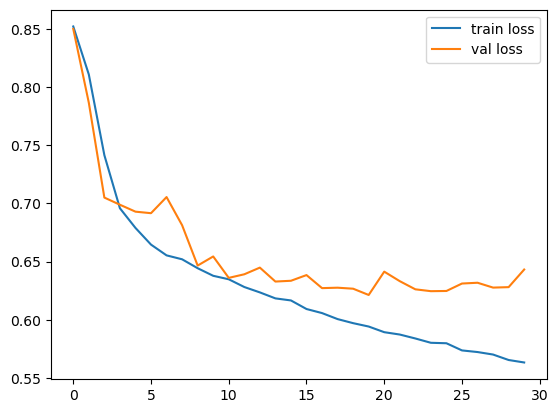

In [31]:
plot_history(history)

In [32]:
images_clear_val = np.load('images_clear_val.npy')
images_noised_val = np.load('images_noised_val.npy')
y = predict_all(model, images_noised_val[:400])

1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=12.079309463500977
mean SSIM=0.4610402584075928


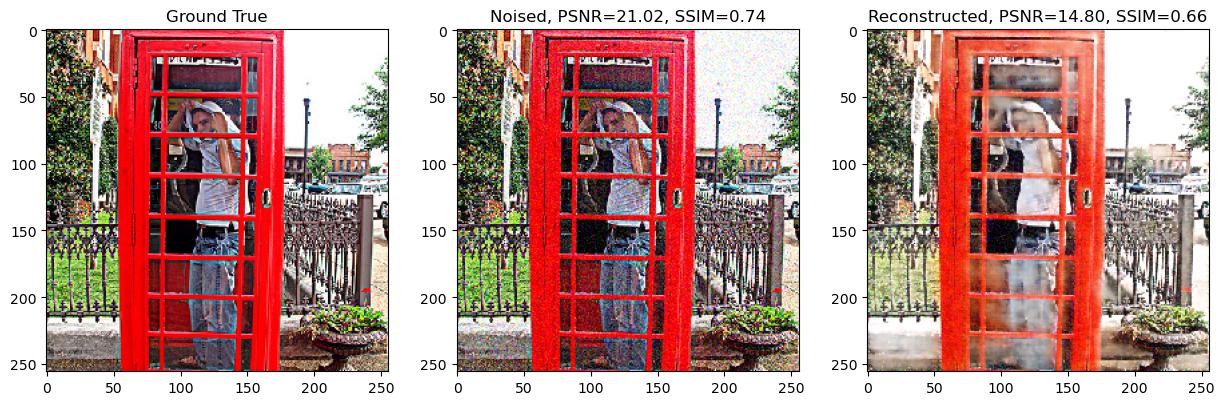

In [33]:
n=334
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_val, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_val[n],
            images_noised_val[n],
            y[n],
            max_value=max_value
           )

In [13]:
y_tt = predict_all(model, images_noised_tt[:100])

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=12.860489845275879
mean SSIM=0.43963515758514404


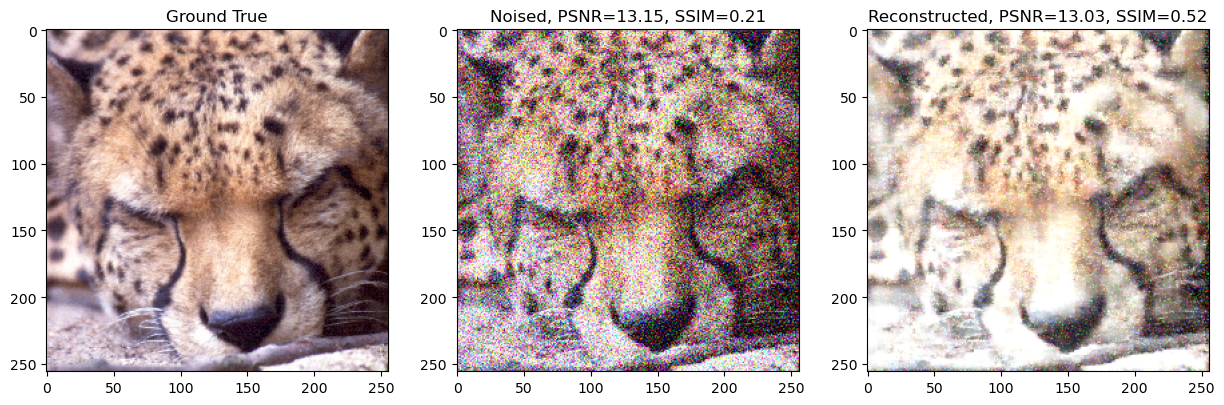

In [14]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_tt, y_tt, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_tt[n],
            images_noised_tt[n],
            y_tt[n],
            max_value=max_value
           )

In [16]:
import importlib

importlib.reload(plot_result())

TypeError: plot_result() missing 3 required positional arguments: 'image_clear', 'image_noised', and 'image_reconstructed'